<font size="4">  
    ML 5632 Final Project: NY Times Best Restaurants of 2024
</font> 
<font size="3">  
    <ul>
        <li>Dataset is taken from <a href="https://www.kaggle.com/datasets/rummagelabs/nytimes-best-restaurants-2024" target="_blank">Kaggle</a></li>
        <li>The goal of this project is to accurately classify top restaurant descriptions into predefined categories</li>
    </ul>
</font> 

In [682]:
# import libraries
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
from sklearn.decomposition import NMF
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

pd.set_option('display.max_columns', None)

In [683]:
# connect to Kaggle dataset locally and display contents
df = pd.read_csv('nytimes_best_restaurants_2024.csv')
df.head()

,restaurant_name,city,state,address,description,cuisine_type,head_chef_or_lead,website
0,Mr. Baan’s Bar and Mookata,Phoenix,AZ,"218 E Portland St #B, Phoenix, AZ 85004",Mr. Baan’s Bar and Mookata offers a vibrant at...,Thai,"Alex Martin, Yotaka ""Sunny"" Martin",https://www.mrbaans.com/
1,Fikscue,Alameda,CA,"1708 Park St Ste 120, Alameda, CA 94501",Fikscue is a vibrant Indonesian-Texan barbecue...,Indo-Tex,"Fik Saleh, Reka Saleh",https://www.fikscue.com/
2,Azizam,Los Angeles,CA,"2943 W Sunset Blvd, Los Angeles, CA 90026",Azizam is a cozy Persian eatery nestled in Sil...,Persian,Cody Ma,https://www.azizamla.com/
3,Camélia,Los Angeles,CA,"1850 Industrial St, Los Angeles, CA 90021",Camélia is a charming French-Japanese bistro i...,French-Japanese,Charles Namba and Courtney Kaplan,https://cameliadtla.com/
4,Four Kings,San Francisco,CA,"710 Commercial St, San Francisco, CA 94108",Four Kings offers a cozy bar ambiance where gu...,Cantonese,Franky Ho and Mike Long,https://www.itsfourkings.com/


I am creating this model to see if we can find any correlations between the different factors. I will try to find a correlation between the description and cuisine type. I hypothesize there is no correlation. I will transform the cuisine type to categories to hopefully have better results for the NMF unsupervised model.

EDA

<ul>
    <li>
        Check for any blanks as well as duplicate entries
    </li>
    <li>
        Drop the website feature as this is not necessary
    </li>
    <li>
        rename some features for easier readability
    </li>
    <li>
        Reclassify the cuisine type to each region
    </li>
</ul>

In [684]:
df = df.rename(columns={"restaurant_name": "Restaurant", "cuisine_type": "Category", "description": "Description"})

# remove any potential blank Text
blank_name_index = df[(df.Restaurant == ' ')].index
df = df.drop(blank_name_index)

blank_description_index = df[(df.Description == ' ')].index
df = df.drop(blank_description_index)

# reclassify Category
df['Category'] = df['Category'].replace({'Thai': 'Asian', 
                             'Indo-Tex': 'North American',
                             'Persian': 'Middle Eastern', 
                             'French-Japanese': 'European',
                             'Cantonese': 'Asian',
                             'Italian, New American': 'North American',
                             'Vietnamese': 'Asian',
                             'Chinese, Cantonese': 'Asian',
                             'New American': 'North American',
                             'Italian, Pizza': 'European',
                             'Indian': 'Asian',
                             'French': 'European',
                             'Scottish': 'European',
                             'Steakhouse': 'North American',
                             'Southern': 'North American',
                             'Mexican': 'North American',
                             'Korean': 'Asian',
                             'Levantine': 'European',
                             'Hmong': 'Asian',
                             'Oyster, New American': 'North American',
                             'Soul Food, Southern': 'North American',
                             'Soul Food': 'North American',
                             'Guamanian': 'Asian',
                             'Mediterranean': 'European',
                             'Bistro': 'European',
                             'Thai, Chinese': 'Asian', 
                             'French, New American': 'European',
                             'Polish': 'European',
                             'Nordic Seafood': 'European',
                             'Barbecue': 'North American',
                             'Seafood': 'North American',
                             'Raw Bar': 'North American',
                             'Laotian': 'Asian',
                             'Kurdish, Turkish': 'Middle Eastern'
                             })

# print unique cuisine_type
print(df['Category'].value_counts())

# drop website feature
df = df.drop(columns=['website'])

# remove duplicate description
df = df.drop_duplicates(subset=['Description'])
print('\nTotal Description Duplicates Found: ', df.duplicated(subset=['Description']).sum())

# remove duplicate restaurant_name
df = df.drop_duplicates(subset=['Restaurant'])
print('\nTotal Restaurant Name Duplicates Found: ', df.duplicated(subset=['Restaurant']).sum())

# visually inspect cleaned data for oddities
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df)

Category
North American    24
Asian             13
European          10
Middle Eastern     3
Name: count, dtype: int64

Total Description Duplicates Found:  0

Total Restaurant Name Duplicates Found:  0


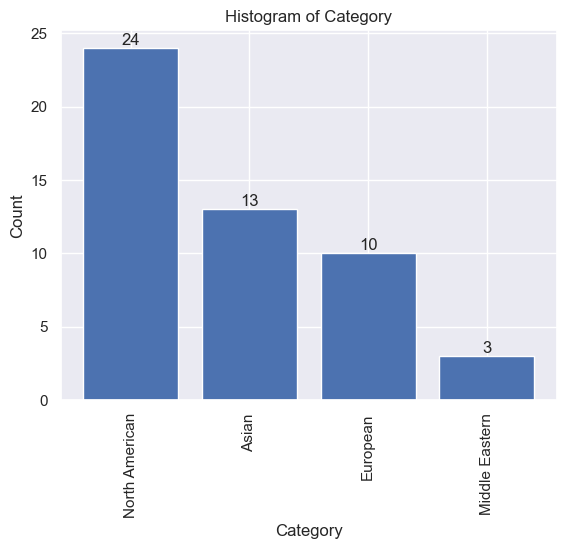

In [685]:
value_counts = df['Category'].value_counts()
plt.bar(value_counts.index, value_counts)
plt.title('Histogram of Category')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Category')
plt.ylabel('Count')

for i, count in enumerate(value_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

Next we'll do some word processing to separate out the words from the description column. We only care about the words and not any symbols or punctuation. We will also remove no descriptive or boring words to show the most used words in the description box.

In [686]:
# split words
texts = df['Description'].str.split().explode()
# remove symbols
texts = texts.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
# make all words lowercase so we get unique words
texts = texts.str.lower()
# remove spaces
texts = texts.str.replace(' ', '', regex=True)

# remove non descriptive and uninteresting words that are in the top 20
stopwords = ['is', 'a', 'and', 'the', 'in', 'of', 'for', 'that', 'by', 'an', 'its', 'with', 'to', 'on', 'it', 'restaurant']
cleanedText = []

for text in texts:
    if text in stopwords:
        continue
    cleanedText.append(text)

df_cleaned_text = pd.DataFrame(cleanedText, columns=['values'])
word_freq = df_cleaned_text['values'].value_counts()
data = [go.Bar(x=word_freq.index[:20], y=word_freq.values[:20])]
layout = go.Layout(title='Top 20 word frequencies')
fig = go.Figure(data=data, layout=layout)
iplot(fig)


Next we'll use TF-IDF to vectorize the data to be used in a unsupervised NFM model. We will also assign a unique identifier to each category to convert strings to ints to make processing easier.

In [687]:
# unsupervised learning (NMF)
n_components = 4
vectorizer_train = TfidfVectorizer(sublinear_tf=True, max_features=5000, min_df=n_components, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features_train = vectorizer_train.fit_transform(df.Description).toarray()
features_train.shape

nmf = NMF(n_components=n_components, random_state=42)
matrix_train = nmf.fit_transform(features_train)
df['pred'] = matrix_train.argmax(axis=1)

# assign unique identifier to category for better processing
unique_values_train = df['Category'].unique()
value_to_int_train = {value: i for i, value in enumerate(unique_values_train)}
df['CategoryID'] = df['Category'].map(value_to_int_train)

# map predicted value to category based on most frequent label
def mapCategories():
    cats = {}
    for i in range(n_components):
        labels = df[df['pred'] == i]['CategoryID']
        if len(labels) > 0:
            cats[i] = labels.mode().iloc[0]
    return cats

mappings = mapCategories()
df['mapped'] = df['pred'].map(mappings)

print("\nReport:")
print(classification_report(df.CategoryID, df['mapped'], target_names=df.Category.unique()))


Report:
                precision    recall  f1-score   support

         Asian       0.50      0.54      0.52        13
North American       0.56      0.83      0.67        24
Middle Eastern       0.00      0.00      0.00         3
      European       0.00      0.00      0.00        10

      accuracy                           0.54        50
     macro avg       0.26      0.34      0.30        50
  weighted avg       0.40      0.54      0.45        50



c:\Users\chris\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Text(92.24999999999999, 0.5, 'True Labels')

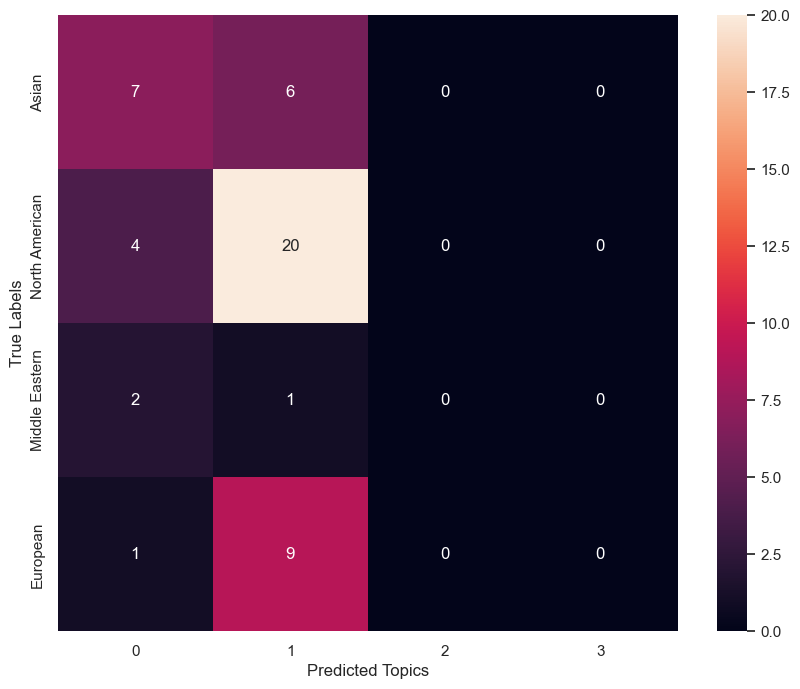

In [688]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(df.CategoryID, df['mapped']), annot=True, fmt='d', xticklabels=range(n_components), yticklabels=df.Category.unique())
plt.xlabel('Predicted Topics')
plt.ylabel('True Labels')

As we can see above the NMF unsupervised model returns a lower accuracy of 54% and the confusion matrix looks mixed as well. We will attempt to tune and hyperparameterize to see if we can make this any better. I suspect not as 54% will be as good as it gets with the mixed data.

In [689]:
nmf = NMF(init='random',n_components=n_components, random_state=42,solver='mu')
matrix = nmf.fit_transform(features_train)
df['pred'] = matrix.argmax(axis=1)
df['mapped'] = df['pred'].map(mapCategories())
nmf_accuracy = accuracy_score(df.CategoryID, df['mapped'])
print('Tuned Hyperparameter Accuracy: ', nmf_accuracy)

Tuned Hyperparameter Accuracy:  0.54


As we can see the accuracy hasn't change hardly at all. This is what I suspected with a accuracy already mixed with the mixed data set. Next we will try a supervised decision tree classifier model to compare to cross validate our results.

In [690]:
X = df[['mapped']].values
y = np.array([int(label) for label in df['CategoryID']])

test_sizes = [.1, .2, .4, .5]

for i in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=42)
    clf = DecisionTreeClassifier(max_depth=2)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Supervised Learning DTC Accuracy: {accuracy} ({i})')

Supervised Learning DTC Accuracy: 0.6 (0.1)
Supervised Learning DTC Accuracy: 0.6 (0.2)
Supervised Learning DTC Accuracy: 0.55 (0.4)
Supervised Learning DTC Accuracy: 0.48 (0.5)


After running the supervised DTC model it looks like the accuracy went down over several iterations of testing size. It looks like the unsupervised model works best in this case.

Conclusion

The sklearn NMF library may not have worked as well because the data set is limited to the amount of information it provides. The description field varies with the sentence structure and vocabulary. The data would be better modeled if there was a numeric rating instead of a narrative field associated with each restaurant. Vectorizing additional features would provide the model with more context about the restaurants. 